In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import LogLocator, ScalarFormatter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from plato.instrument.detection import DetectionModel
from plato.stars import filter_p1_targets, filter_valid_targets
from plato.utils import create_grid, iterate_detectable_fraction
from plato.visualisation import (
    FigureProcessor,
    contour_plot,
    get_earth_marker,
    get_palette,
    set_plot_defaults,
)

In [16]:
set_plot_defaults()

figure_directory = f"../figures/05_detection_efficiency/"
save = True

In [17]:
LOPS2 = pd.read_csv(f"../data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(f"../data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[["Radius", "Mass", "u1", "u2", "gaiaV", "n_cameras", "Population"]]

fields["cos_i"] = 0
fields["sigma_star"] = 1e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

p1_sample = filter_p1_targets(fields)

## PLOT EXAMPLE DETECTION EFFICIENCY

In [22]:
# create planet property grid
n_example = 1000
porb, r_planet, planet_grid = create_grid(
    n_example,
    (1, 730),
    (0.3, 1.2),
    space="geom",
    return_as="dataframe",
    columns=["P_orb", "R_planet"],
)

planet_grid = planet_grid.assign(  # type: ignore
    R_star=1,
    M_star=1,
    Magnitude_V=11,
    n_cameras=24,
    cos_i=0,
    sigma_star=10e-6,
    u1=0.4,
    u2=0.15,
)

detection_efficiency = (
    DetectionModel().detection_efficiency(planet_grid).reshape(n_example, n_example)  # type: ignore
)

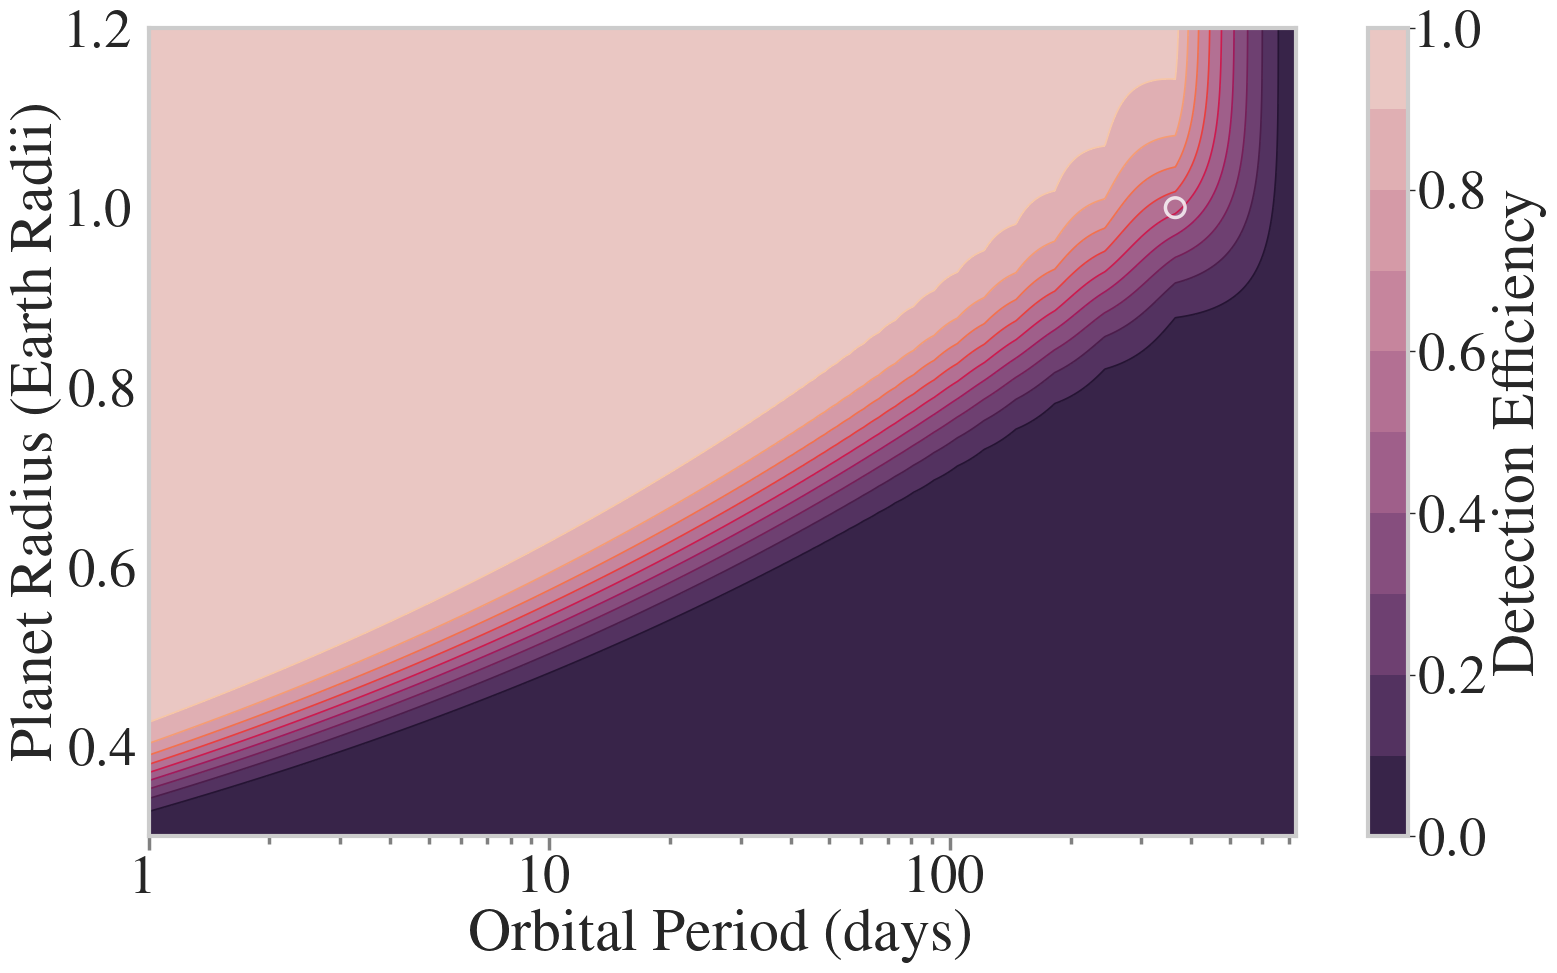

In [23]:
fig, ax, cbar = contour_plot(
    porb,
    r_planet,
    detection_efficiency,
    contourf_kwargs={
        "levels": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "cmap": get_palette(n_colors=10, as_cmap=True, reverse=True),
    },
    contour_kwargs={
        "levels": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    },
)

# adjust ticks
ax.set_xscale("log")
ax.tick_params(
    axis="x",
    which="both",
    direction="out",
    bottom=True,
    left=True,
    color="grey",
    width=2.5,
)
ax.tick_params(axis="x", which="major", length=10)
ax.tick_params(axis="x", which="minor", length=6)
ax.xaxis.set_major_locator(LogLocator())
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel("Orbital Period (days)")
ax.set_ylabel("Planet Radius (Earth Radii)")

# add marker for earth
ax.scatter(**get_earth_marker())

cbar.set_label("Detection Efficiency")


FigureProcessor(fig).save(
    "detection_efficiency_example_contour.pdf",
    figure_directory=figure_directory,
    save=save,
)

## PLOT DETECTION EFFICIENCY FOR FIELD TARGETS

In [13]:
# create planet property grid
n_example = 50
porb, r_planet, planet_grid = create_grid(
    n_example,
    (1, 730),
    (0.1, 10),
    space="geom",
    return_as="dataframe",
    columns=["P_orb", "R_planet"],
)

In [14]:
detection_effs_samples = []

# compute detection efficiency for P1 and all targets
# 'detectable' if detection efficiency > 1/N
for sample in [p1_sample, fields]:
    effs = iterate_detectable_fraction(
        planet_grid,  # type: ignore
        sample,
        DetectionModel(),
        detection_threshold=1 / len(sample),
        reshaping_bins=n_example,
    )
    detection_effs_samples.append(effs)

KeyboardInterrupt: 

In [ ]:
for name, sample in zip(["p1", "all"], detection_effs_samples):
    fig, ax, cbar = contour_plot(
        porb,
        r_planet,
        sample,
        contourf_kwargs={
            "levels": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            "cmap": get_palette(n_colors=10, as_cmap=True, reverse=True),
        },
        contour_kwargs={
            "levels": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        },
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    # adjust ticks
    ax.tick_params(
        axis="both",
        which="both",
        direction="out",
        bottom=True,
        left=True,
        width=2.5,
        color="grey",
    )
    ax.tick_params(axis="both", which="major", length=10)
    ax.tick_params(axis="both", which="minor", length=6)
    ax.xaxis.set_major_locator(LogLocator())
    ax.xaxis.set_major_formatter(ScalarFormatter())

    ax.set_xlabel("Orbital Period (days)")
    ax.set_ylabel("Planet Radius (Earth Radii)")

    # add marker for earth
    ax.scatter(**get_earth_marker())

    cbar.set_label("Fraction of Detectable Planets")

    FigureProcessor(fig).save(
        f"detection_efficiency_fraction_{name}.pdf",
        figure_directory=figure_directory,
        save=save,
    )

## PLOT DETECTION EFFICIENCY DISTRIBUTION FOR EARTH

In [ ]:
earth_effs = fields.copy()
earth_effs["Detection Efficiency"] = DetectionModel().detection_efficiency(
    earth_effs.assign(
        P_orb=365,
        R_planet=1,
    )
)

In [ ]:
# bin earth_effs by detection efficiency and calcute magnitudes
bins = 20

earth_effs["Detection Efficiency Bins"] = pd.cut(
    earth_effs["Detection Efficiency"],
    bins=bins,
    labels=False,
)
bin_V = earth_effs.groupby("Detection Efficiency Bins")["Magnitude_V"].mean()

# create colormap based on binned magnitudes
norm = Normalize(vmin=bin_V.min(), vmax=bin_V.max())

# map the normalized values to a colormap
cmap = get_palette(n_colors=bins, as_cmap=True)
colors = cmap(norm(bin_V.values))  # type: ignore

In [ ]:
earth_eff_hist = sns.histplot(
    earth_effs,
    x="Detection Efficiency",
    bins=bins,
    edgecolor="black",
)
earth_eff_hist.set_yscale("log")

# get the patches (bars) of the histogram, and set their color
patches = earth_eff_hist.patches
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# create a ScalarMappable and add a color bar
sm = ScalarMappable(cmap=cmap, norm=norm)  # type: ignore
cbar = plt.colorbar(sm, ax=earth_eff_hist)
cbar.set_label("Mean Magnitude")

earth_eff_hist.set_xlim(0, 0.94)
earth_eff_hist.set_ylabel("Number of Planets")

FigureProcessor(earth_eff_hist).save(
    "Earthlike_detection_eff_hist.pdf",
    figure_directory=figure_directory,
    save=save,
)

## PLOT DETECTION EFFICIENCY AS FUNCTION OF RADIUS

In [ ]:
# create planet property grid
n_example = (1, 100)
porb, r_planet, planet_grid = create_grid(
    n_example,
    (50, 50),
    (0.1, 10),
    space="geom",
    return_as="dataframe",
    columns=["P_orb", "R_planet"],
)

In [ ]:
detection_effs_pops = []

# compute detection efficiency for P1 and all targets
# 'detectable' if detection efficiency > 1/N
for pop in ["Halo", "Thick Disk", "Thin Disk"]:
    sample = fields[fields["Population"] == pop].copy()
    effs = iterate_detectable_fraction(
        planet_grid,  # type: ignore
        sample,
        DetectionModel(),
        detection_threshold=1 / len(sample),
        reshaping_bins=n_example,
    )

    effs = pd.DataFrame(
        np.array([r_planet, effs[0]]).T,
        columns=[f"Planet Radius", "Fraction of Detectable Planets"],
    )
    effs["Population"] = pop

    detection_effs_pops.append(effs)

detection_effs_pops = pd.concat(detection_effs_pops)

In [ ]:
detectioneff_lineplot = sns.lineplot(
    data=detection_effs_pops,
    x="Planet Radius",
    y="Fraction of Detectable Planets",
    hue="Population",
    hue_order=["Thin Disk", "Thick Disk", "Halo"],
    palette=get_palette(n_colors=3),
    linewidth=10,
)

detectioneff_lineplot.set_xscale("log")
detectioneff_lineplot.get_legend().set_title("")

# adjust ticks
detectioneff_lineplot.tick_params(
    axis="x",
    which="both",
    direction="out",
    bottom=True,
    left=True,
    width=2.5,
    color="grey",
)
detectioneff_lineplot.tick_params(axis="x", which="major", length=10)
detectioneff_lineplot.tick_params(axis="x", which="minor", length=6)
detectioneff_lineplot.xaxis.set_major_locator(LogLocator())
detectioneff_lineplot.xaxis.set_major_formatter(ScalarFormatter())

FigureProcessor(detectioneff_lineplot).save(
    "detectioneff_planet_radius.pdf",
    figure_directory=figure_directory,
    save=save,
)